# 第5部　線形ガウス状態空間モデル

## 第3章　ローカルレベルモデルの実装

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns
sns.set()

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### シミュレーションデータの生成

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
mu = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size).round(1)) + 30

# 観測値の作成
y = mu + stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)

# 時系列インデックスの付与
y_ts = pd.Series(
    y, index=pd.date_range(start='2020-01-01', periods=sim_size, freq='D'))

### カルマンフィルタを実行するクラスの作成

In [4]:
class LocalLevel:
    # データを格納(pd.Seriesで、日付インデックスがついている想定)
    def __init__(self, ts_data):
        self.ts_data = ts_data
        self.a = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.P = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.v = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.F = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.K = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.s_level = None     # 過程誤差の分散
        self.s_irregular = None # 観測誤差の分散

    # 状態の初期値を設定する
    def initialize(self, initial_a, initial_P):
        self.initial_a = initial_a
        self.initial_P = initial_P
        
    # 1時点先の予測値を計算する
    def _forecast_step(self, a_pre, P_pre, s_irregular, s_level, first=False):
        if first:
            a_forecast = self.initial_a    # 初回に限り、初期値を代入
            P_forecast = self.initial_P    # 初回に限り、初期値を代入
        else:
            a_forecast = a_pre             # 状態の予測値
            P_forecast = P_pre + s_level   # 状態の予測値の分散

        y_forecast = a_forecast            # 観測値の予測値
        F = P_forecast + s_irregular       # 観測値の予測値の残差の分散
        
        return(pd.Series([a_forecast, P_forecast, y_forecast, F], 
                         index=['a', 'P', 'y', 'F']))

    # 1時点のフィルタリングをする
    def _filter_step(self, forecasted, y, s_irregular):
        v = y - forecasted.y                # 観測値の1時点先予測値の残差
        K = forecasted.P / forecasted.F     # カルマンゲイン
        a_filter = forecasted.a + K * v     # フィルタ化推定量
        P_filter = (1 - K) * forecasted.P   # フィルタ化推定量の分散
        
        return(pd.Series([a_filter, P_filter, v, K], 
                         index=['a', 'P', 'v', 'K']))

    # フィルタリングを行う
    def filter(self, s_irregular, s_level):
        for i in range(0, len(self.ts_data)):
            if(i == 0):
                # 初回のみ、初期値の値を利用して予測する
                forecast_loop = self._forecast_step(
                    a_pre=None, P_pre=None, 
                    s_irregular=s_irregular, s_level=s_level, first=True)
            else:
                # 2時点目以降は、1時点前の値を参照して予測する
                forecast_loop = self._forecast_step(
                    a_pre=self.a.iloc[i - 1], P_pre=self.P.iloc[i - 1], 
                    s_irregular=s_irregular, s_level=s_level)
            
            # フィルタリングの実行
            filter_loop = self._filter_step(
                forecasted=forecast_loop, y=self.ts_data.iloc[i],
                s_irregular=s_irregular
            )

            # 結果の保存
            self.a.iloc[i] = filter_loop.a
            self.P.iloc[i] = filter_loop.P
            self.F.iloc[i] = forecast_loop.F
            self.K.iloc[i] = filter_loop.K
            self.v.iloc[i] = filter_loop.v

    # 対数尤度の計算
    def llf(self):
        return np.sum(np.log(stats.norm.pdf(
            x=self.v, loc=0, scale=np.sqrt(self.F)
        )))

    # パラメータの推定と状態の再当てはめ
    def fit(self, start_params):
        # パラメータを指定して対数尤度の-1倍を出力する内部関数
        def calc_llf(params):
            self.filter(np.exp(params[0]), np.exp(params[1]))
            return self.llf() * -1

        # 最適化の実行
        opt_res = minimize(calc_llf, start_params, 
                           method='Nelder-Mead', tol=1e-6, 
                           options={'maxiter':2000})
        
        # パラメータの保存
        self.s_irregular = np.exp(opt_res.x[0])
        self.s_level = np.exp(opt_res.x[1])

        # 最適なパラメータでもう一度フィルタリングを行う
        self.filter(self.s_irregular, self.s_level)

    # 推定された状態の可視化
    def plot_level(self):
        plot_df = pd.concat([self.a, self.ts_data], axis=1)
        plot_df.columns = column=['filtered', 'y']
        plot_df.plot()

### カルマンフィルタの実行

In [5]:
# データを格納
local_level = LocalLevel(y_ts)

# 初期化
local_level.initialize(initial_a=0, initial_P=1000000)

# フィルタリング
local_level.filter(s_irregular=10, s_level=1)

In [6]:
# フィルタ化推定量
local_level.a.round(5).head(3)

2020-01-01    29.39971
2020-01-02    33.43318
2020-01-03    33.07468
Freq: D, dtype: float64

In [7]:
# 参考：フィルタ化推定量の分散
local_level.P.round(5).head(3)

2020-01-01    9.99990
2020-01-02    5.23807
2020-01-03    3.84163
Freq: D, dtype: float64

In [8]:
# 観測値の1時点先予測値の残差
local_level.v.round(5).head(3)

2020-01-01    29.40000
2020-01-02     7.70029
2020-01-03    -0.93318
Freq: D, dtype: float64

In [9]:
# 参考：観測値の1時点先予測値の残差の分散
local_level.F.round(5).head(3)

2020-01-01    1.000010e+06
2020-01-02    2.099990e+01
2020-01-03    1.623807e+01
Freq: D, dtype: float64

In [10]:
# カルマンゲイン
local_level.K.round(5).head(3)

2020-01-01    0.99999
2020-01-02    0.52381
2020-01-03    0.38416
Freq: D, dtype: float64

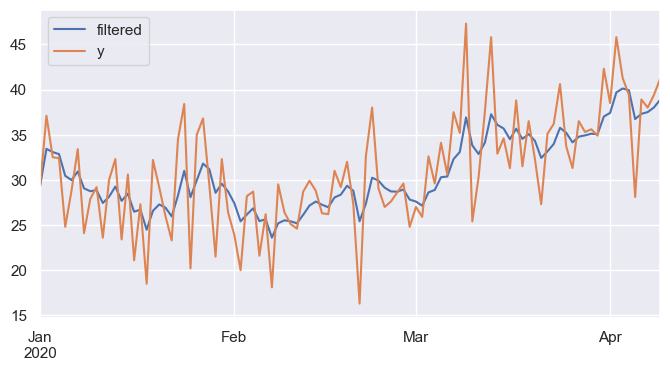

In [11]:
# 推定された状態の可視化
local_level.plot_level()

### パラメータを変えた場合の挙動

#### 状態の初期分散が小さい場合

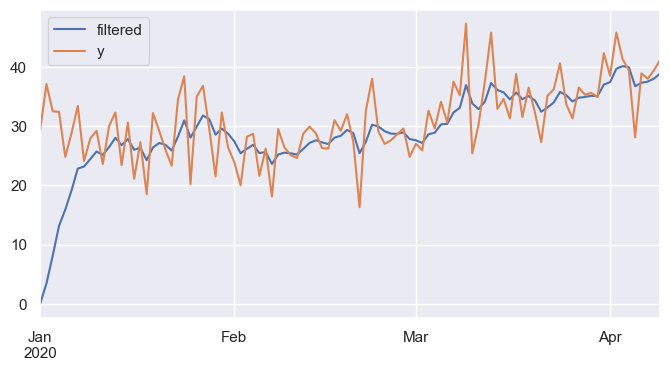

In [12]:
# 初期化
local_level.initialize(initial_a=0, initial_P=0.01)

# フィルタリング
local_level.filter(s_irregular=10, s_level=1)

# 推定された状態の可視化
local_level.plot_level()

#### 観測誤差の分散が非常に大きい場合

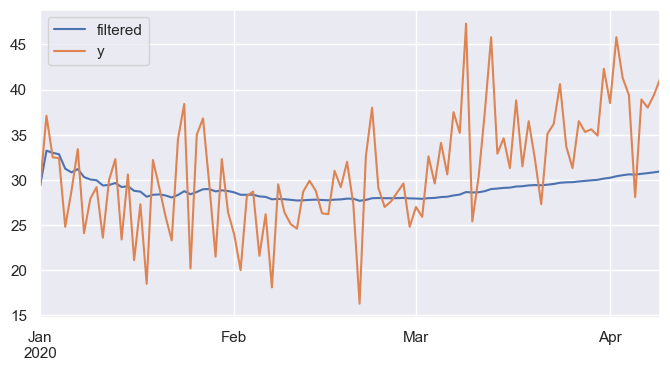

In [13]:
# 初期化
local_level.initialize(initial_a=0, initial_P=1000000)

# フィルタリング
local_level.filter(s_irregular=1000, s_level=0.001)

# 推定された状態の可視化
local_level.plot_level()

#### 観測誤差の分散が非常に小さい場合

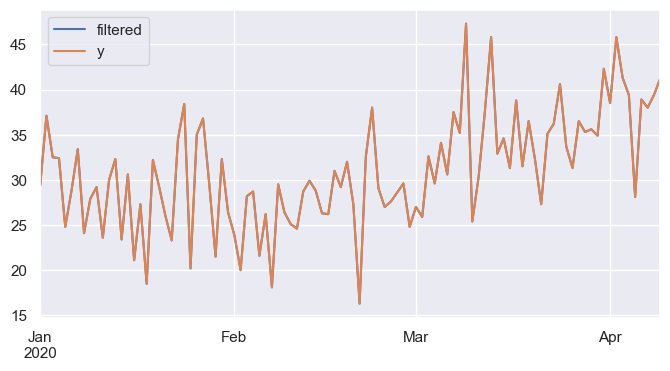

In [14]:
# 初期化
local_level.initialize(initial_a=0, initial_P=1000000)

# フィルタリング
local_level.filter(s_irregular=0.001, s_level=1000)

# 推定された状態の可視化
local_level.plot_level()

### 最尤法によるパラメータの推定

#### 対数尤度の計算

In [15]:
# 初期化
local_level.initialize(initial_a=0, initial_P=1000000)

# フィルタリング
local_level.filter(s_irregular=10, s_level=1)

# 対数尤度
local_level.llf()

-328.7964774283829

#### パラメータの推定

In [16]:
# パラメータの推定
local_level.fit(start_params=[1, 1])

# 対数尤度
local_level.llf()

-311.71335569235623

In [17]:
# 推定されたパラメータ
print('観測誤差の分散', np.round(local_level.s_irregular, 5))
print('過程誤差の分散', np.round(local_level.s_level, 5))

観測誤差の分散 22.49697
過程誤差の分散 0.6952


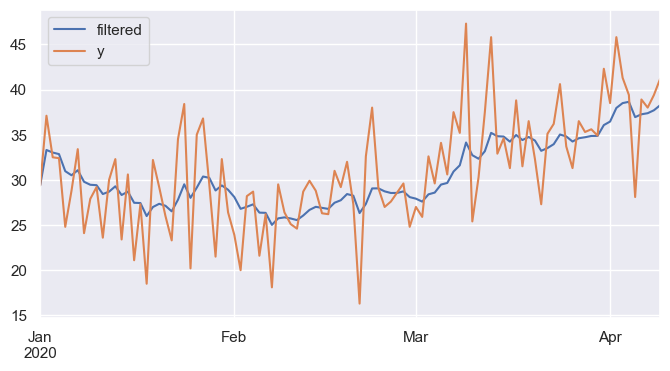

In [18]:
# 参考：推定された状態の可視化
local_level.plot_level()

### statsmodelsの利用

#### パラメータを固定してフィルタリング

In [19]:
# データの格納とモデルの特定
mod_local_level_fix = tsa.UnobservedComponents(
    y_ts, level='local level', loglikelihood_burn=0)

In [20]:
# 初期化
mod_local_level_fix.initialize_approximate_diffuse(1000000)

In [21]:
# フィルタリング
res_local_level_fix = mod_local_level_fix.filter(pd.Series(np.array([10, 1])))

In [22]:
# フィルタ化推定量を取り出す
np.round(res_local_level_fix.level["filtered"][0:3], 5)

array([29.39971, 33.43318, 33.07468])

In [23]:
# 対数尤度を取り出す
np.round(res_local_level_fix.llf, 5)

-328.79648

In [24]:
# 参考
print(res_local_level_fix.summary())

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -328.796
Date:                Wed, 11 Sep 2024   AIC                            661.593
Time:                        16:47:27   BIC                            666.803
Sample:                    01-01-2020   HQIC                           663.702
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    10.0000      0.747     13.381      0.000       8.535      11.465
sigma2.level         1.0000      0.257      3.891      0.000       0.496       1.504
Ljung-Box (L1) (Q):         

#### パラメータの推定

In [25]:
# ローカルレベルモデルの推定

# データの格納とモデルの特定
mod_local_level = tsa.UnobservedComponents(
    y_ts, level='local level', loglikelihood_burn=0)

# 初期化
mod_local_level.initialize_approximate_diffuse(1000000)

# フィルタリングと最尤法によるパラメータの推定
res_local_level = mod_local_level.fit(
    start_params=[1,1], method='nm', maxiter=2000)

# 結果の出力
print(res_local_level.summary())

Optimization terminated successfully.
         Current function value: 3.117134
         Iterations: 48
         Function evaluations: 92
                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -311.713
Date:                Wed, 11 Sep 2024   AIC                            627.427
Time:                        16:47:27   BIC                            632.637
Sample:                    01-01-2020   HQIC                           629.535
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    22.4973      3.659      6.149      0.000

In [26]:
# 参考：お手製のカルマンフィルタと結果がほぼ同じになっていることの確認
np.sum((local_level.a - res_local_level.level["filtered"]) ** 2)

4.3155904268713204e-08

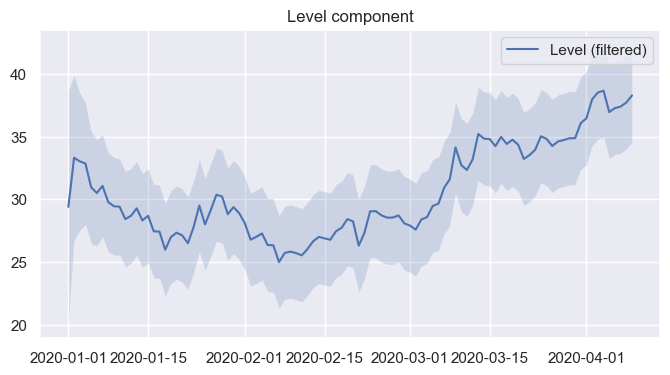

In [27]:
# フィルタ化推定量の描画
_ = res_local_level.plot_components(which="filtered", observed=False)

### 状態の平滑化

In [28]:
# 平滑化推定量を取り出す
np.round(res_local_level.level["smoothed"][0:3], 5)

array([30.19488, 30.21947, 30.03142])

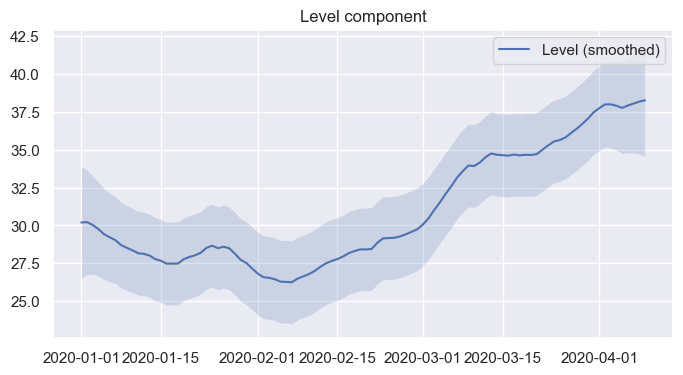

In [29]:
# 平滑化推定量の描画
_ = res_local_level.plot_components(which="smoothed", observed=False)